## 신경망 - Neural networks
##### torch.nn 패키지를 사용하여 신경망을 구축할 수 있습니다.
##### 지금까지 autograd를 살펴봤는데, nn은 모델을 정의하고 미분하는데 autograd를 사용합니다.
##### nn.Module은 계층과 output을 반환하는 forward(input)과 계층들을 포함하고 있습니다.
##### 예를들어, 숫자 이미지를 분류하는 신경망을 살펴보겠습니다.


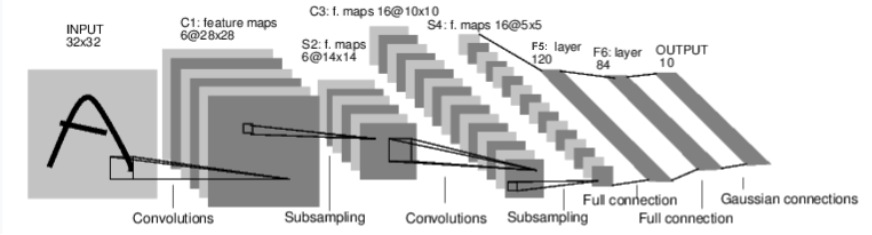

##### 이는 간단한 순전파 네트워크(feed-forward network)입니다.
##### input을 받고, 여러 계층을 순서대로 걸쳐서 전달하고, 최종적으로 ouput을 반환합니다.

### 신경망의 전형적인 학습 절차는 다음과 같습니다.

1. 학습가능한 매개변수(또는 가중치(weights))를 갖고 있는 신경망을 정의합니다.
2. 데이타셋의 입력을 반복합니다.
3. 입력을 신경망에서 전파(process)합니다.
4. 손실을 계산합니다.(출력값이 정답으로부터 얼마나 멀리 떨어져있는지)
5. 신경망의 매개변수에 변화도를 역으로 전파합니다.
6. 신경망의 가중치를 갱신합니다. 일반적으로 간단한 갱신 규칙을 사용합니다. (weight = weight - learning_rate * gradient)


## 신경망 정의하기


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 입력 이미지 채널 1개, 출력 채널 6개, 3x3의 정사각 컨볼루션 행렬
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # 어파인 연산 : y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120) # 6*6은 이미지 차원에 해당
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # (2, 2) 크기 윈도우에 대해 맥스 풀링
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 크기가 정사각형이면 하나의 숫자만을 명시
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:] # 배치 차원을 제외한 모든 차원
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


##### forward 함수를 정의하고 나면 autograd를 사용하여 backward 함수를 자동으로 정의합니다.
##### forward 함수에서 어떠한 Tensor 연산을 사용할 수 있습니다.
##### 모델의 학습가능한 매개변수들은 net.parameters()에 의해 반환받습니다.

In [5]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1의 가중치

10
torch.Size([6, 1, 3, 3])


##### 임의의 32x32 입력값을 해보겠습니다.

##### 이 신경망(LeNet)의 예상되는 입력 사이즈는 32x32입니다.

##### 이 신경망에 MNIST 데이터셋을 사용하기 위해 데이터셋의 이미지 크기를 32x32로 변경해야 합니다.

In [6]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0755,  0.0196, -0.0362, -0.0312, -0.1341,  0.0021,  0.0979,  0.0230,
          0.1268, -0.0627]], grad_fn=<AddmmBackward0>)


##### 모든 매개변수의 변화도 버퍼(gradient buffers)를 0으로 하고, 무작위 변화도로 역전파를 합니다.

In [7]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### Note
##### torch.nn은 미니-배치(mini-batches)만을 지원합니다.
##### 모든 torch.nn 패키지는 하나의 샘플이 아닌, 샘플들의 미니-배치만을 입력으로 받습니다.

##### 예를 들어, nn.Conv2d는 nSamples x nChannels x Height x Width의 4차원 Tensor를 입력으로 합니다.

##### 만약 하나의 샘플을 갖고 있다면, 가상의 배치 차원을 추가하기 위해 input.unsqueeze(0)을 사용하면 됩니다. 

### 복습

* torch.Tensor - backward() 같은 자동 미분 연산을 위한 다차원 배열입니다. 또한 tensor에 대한 변화도를 갖고 있습니다.
* nn.Module - 신경망 모듈입니다. 매개변수를 캡슐화하는 편리한 방법으로 매개변수를 GPU로 이동, 내보내기, 불러오기 능을 지원합니다.
* nn.Parameter - Tensor의 한 종류입니다. 모듈에 속성으로 할당시켰을 때 자동으로 매개변수로 등록됩니다.
* autograd.Function - 자동 미분 연산의 순전파, 역전파를 구현합니다. 모든 Tensor 연산은 적어도 하나의 Function 노드를 생성하고, 각 노드는 Tensor를 생성하고 이력을 부호화하는 함수들과 연결되어 있습니다.

### 손실 함수 - Loss Function
##### 손실 함수는 입력값의 (output, target) 쌍을 취하고 output이 target과 얼마나 멀리 떨어져 있는지 추정하는 값을 계산합니다.
##### nn package에 수 많은 손실 함수가 있습니다. 간단한 손실은 input과 targer사이의 평균-제곱 오차(mean-squared error)를 계산하는 nn.MSELoss입니다.

In [10]:
output = net(input)
target = torch.randn(10) # target 덩어리
target = target.view(1, -1) # output과 동일한 형태로 만들기
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.7818, grad_fn=<MseLossBackward0>)


##### 지금부터, 이것의 .grad_fn 속성을 사용해서 역전파 방향으로 loss 따라가면, 다음과 같은 계산 그래프를 볼 수 있습니다.

In [11]:
# input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d 
# -> view -> linear -> relu -> linear -> relu -> linear -> MSELoss -> loss
print(loss.grad_fn) # MSELoss
print(loss.grad_fn.next_functions[0][0]) # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # ReLU

##### loss.backward()를 호출했을 때, 전체 그래프는 손실에 대해 미분되어지며 그래프에 존재하는 reguires_grad=True를 갖고 있는 모든 Tensors는 기울기(gradinet)와 축적된 .grad Tensor를 갖게 됩니다.

### 역전파 - Backprop


In [12]:
# 오차를 역전파하기 위해서 해야될 것은 loss.backward() 입니다. 
# 존재하는 변화도(gradients)를 없애는 것이 필요한데 그렇지 않으면 변화도는 기존의 변화도에 누적될 것 입니다.
net.zero_grad() # 모든 매개변수의 변화도 버퍼를 0으로 만들기

print('conv1.bias.grad befort backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)


conv1.bias.grad befort backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0079, -0.0074, -0.0116,  0.0034,  0.0069,  0.0020])


##### 더 읽어볼 거리
##### 신경맹 패키지는 깊은 신경망의 건축 블럭을 형성하는 다양한 모듈과 손실 함수를 포함합니다.
##### https://pytorch.org/docs/stable/nn.html

### 가중치 갱신하기 - Update the weigths

##### 실제로 사용되는 가장 간단한 갱신 방법은 확률론적 경사 하강법(Stochastic Gradient Descent, SGD)입니다.

In [14]:
# 가중치 = 가중치 - 학습률 * 변화도
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [15]:
# torch.optim
import torch.optim as optim

# Optimizer 생성하기
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 학습 과정(training loop)에서
optimizer.zero_grad() # 변화도 버퍼 0으로 만들기
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() # 갱신하기

### Note
##### optimizer.zero_grad()를 사용해서 변화도 버퍼를 수동으로 0으로 설정해야 하는 것에 주의해야 합니다.
##### 역전파 부분에서 설명되었던 것처럼 변화도가 누적되기 때문입니다
